In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import heapq

from scipy.io import wavfile
from IPython.display import Audio, display
from time import time

n = 13 # Quantisation level

def load_wav(path):
    rate, data = wavfile.read(path)

    # Quantise the data
    data = np.floor(data / 2**(16-n)).astype(int)
    return rate, data

# Example usage
path = 'database/F1/SA1.wav'
rate, audio_data = load_wav(path)

In [163]:


def init_table(paths):
    audio_data = []
    for path in paths:
        rate, data = load_wav(path)
        audio_data.extend(data)
    audio_data = np.array(audio_data)


    # Create empty Huffman table
    huffman_table = {}
    # Get symbols and frequencies from data
    symbols, frequencies = np.unique(audio_data, return_counts=True)
    frequency_dict = dict(zip(symbols, frequencies))

    # Account for unused symbols (n bit signed integers)
    all_symbols = np.arange(-2**(n-1), 2**(n-1)).astype(int)
    all_frequencies = np.array([frequency_dict.get(symbol, 0) for symbol in all_symbols])

    # Add the symbols and frequencies to the Huffman table dictionary
    for symbol, frequency in zip(all_symbols, all_frequencies):
        huffman_table[symbol] = {'frequency': frequency, 'codeword': ''}

    # Sort the Huffman table by frequency
    huffman_table = dict(sorted(huffman_table.items(), key=lambda item: item[1]['frequency'], reverse=True))

    return huffman_table

In [164]:
# Node class for Huffman tree
class Node:
   def __init__(self, symbol, frequency):
      self.left = None
      self.right = None
      self.symbol = symbol
      self.frequency = frequency
      self.codeword = ''

   def __lt__(self, other):
        return self.frequency < other.frequency


In [165]:
# Huffman code algorithm
def create_codewords(table, do_print=True):
    time_start = time()
    # Create a priority queue (min-heap) of nodes
    heap = []
    for symbol, data in table.items():
        heapq.heappush(heap, (data['frequency'], Node(symbol, data['frequency'])))

    # Create the Huffman tree
    while len(heap) > 1:
        # Extract the two nodes with the smallest frequencies
        freq1, left = heapq.heappop(heap)
        freq2, right = heapq.heappop(heap)
        # Create a new node with these two nodes as children
        new_node = Node(None, freq1 + freq2)
        new_node.left = left
        new_node.right = right
        # Add the new node back to the heap
        heapq.heappush(heap, (new_node.frequency, new_node))

    if do_print:
        print(f'Binary tree created in {(time() - time_start)*1000:.3f} ms')

    time_start = time()
    
    # The root of the Huffman tree is the only node left in the heap
    _, root = heapq.heappop(heap)
    
    # Generate the Huffman codewords
    stack = [root]
    while stack:
        node = stack.pop()
        if node.symbol is not None:
            table[node.symbol]['codeword'] = node.codeword
        if node.right is not None:
            node.right.codeword = node.codeword + '1'
            stack.append(node.right)
        if node.left is not None:
            node.left.codeword = node.codeword + '0'
            stack.append(node.left)
    if do_print:
        print(f'Codewords generated in {(time() - time_start)*1000:.3f} ms')
    return table, root

In [166]:
# Visualise the Huffman tree
huffman_table = init_table(['database/F1/SA1.wav'])
huffman_table, root = create_codewords(huffman_table)

Binary tree created in 84.407 ms
Codewords generated in 13.559 ms


In [167]:
# Functions to encode and decode the data
def encode(path, table, filename='encoded_data.bin'):

    rate, data = load_wav(path)
    # Encode the data using the Huffman dictionary
    encoded_data = ''.join(table[symbol]['codeword'] for symbol in data)

    # Pad the encoded data to ensure its length is a multiple of 8
    if len(encoded_data) % 8 != 0:
        padding_length = 8 - (len(encoded_data) % 8)
        encoded_data += '0' * padding_length

    # Convert the string of zeros and ones to bytes
    byte_array = int(encoded_data, 2).to_bytes((len(encoded_data) + 7) // 8, byteorder='big')

    # Save the encoded data to a binary file
    with open(filename, 'wb') as file:
        file.write(byte_array)

    return encoded_data

def decode(filename, table):
    # Create a reverse Huffman table
    reverse_table = {table[symbol]['codeword']: symbol for symbol in table}

    # Read the encoded data from the binary file
    with open(filename, 'rb') as file:
        byte_array = file.read()

    # Convert the bytes to a string of zeros and ones
    encoded_data = ''.join(format(byte, '08b') for byte in byte_array)

    # Decode the data using the reverse Huffman table
    decoded_data = []
    code = ''
    for bit in encoded_data:
        code += bit
        if code in reverse_table:
            decoded_data.append(reverse_table[code])
            code = ''


    return np.array(decoded_data)

In [168]:
# Encode the data and save the file
filename = 'encoded_data.bin'

time_start = time()
encoded_data = encode(path, huffman_table, filename=filename)

print(f'Encoding time: {(time() - time_start)*1000:.3f} ms')

time_start = time()
decoded_data = decode(filename, huffman_table)

print(f'Decoding time: {(time() - time_start)*1000:.3f} ms')

print(f'Decoded data size: {len(decoded_data) * n // 8} bites')
print(f'Encoded data size: {len(encoded_data) // 8} bites')
print(f'Compression ratio: {len(decoded_data) * n / len(encoded_data):.2f}')

Encoding time: 15.240 ms
Decoding time: 61.645 ms
Decoded data size: 51584 bites
Encoded data size: 37241 bites
Compression ratio: 1.39


In [169]:
# Play the original and encoded audio files

print('Original audio:')
display(Audio(filename=path))

print('Decoded audio:')
display(Audio(data=decoded_data, rate=rate))

Original audio:


Decoded audio:


In [170]:
# Encode an audio file different from the training data
path_test = 'database/M1/SA2.wav'

filename_test = 'encoded_data_test.bin'

time_start = time()
encoded_test_data = encode(path_test, huffman_table, filename=filename_test)

print(f'Encoding time: {(time() - time_start)*1000:.3f} ms')

time_start = time()
decoded_test_data = decode(filename_test, huffman_table)

print(f'Decoding time: {(time() - time_start)*1000:.3f} ms')

print(f'Decoded data size: {len(decoded_test_data) * n // 8 / 1000} kilobytes')
print(f'Encoded data size: {len(encoded_test_data) // 8 / 1000} kilobytes')
print(f'Compression ratio: {len(decoded_test_data) * n / len(encoded_test_data):.2f}')


Encoding time: 8.996 ms
Decoding time: 132.875 ms
Decoded data size: 30.119 kilobytes
Encoded data size: 42.313 kilobytes
Compression ratio: 0.71


In [171]:
# Play the original and encoded test audio files
print('Original audio:')
display(Audio(filename=path_test))

print('Decoded audio:')
display(Audio(data=decoded_test_data, rate=rate))

Original audio:


Decoded audio:


In [172]:
# Training data
train_paths = [
    'database/F1/SA1.wav',
    'database/M1/SA2.wav',
    'database/F2/SX34.wav',
    'database/M2/SI602.wav',
    'database/F3/SI2114.wav',
    'database/M3/SX199.wav',
    'database/F4/SI2204.wav',
    'database/M4/SI1019.wav'
]

# Test data
test_paths = [
    'database/F1/SI1573.wav',
    'database/M1/SI2293.wav',
    'database/F2/SX304.wav',
    'database/M2/SX374.wav',
    'database/F3/SX134.wav',
    'database/M3/SX289.wav',
    'database/F4/SX224.wav',
    'database/M4/SX389.wav'
]


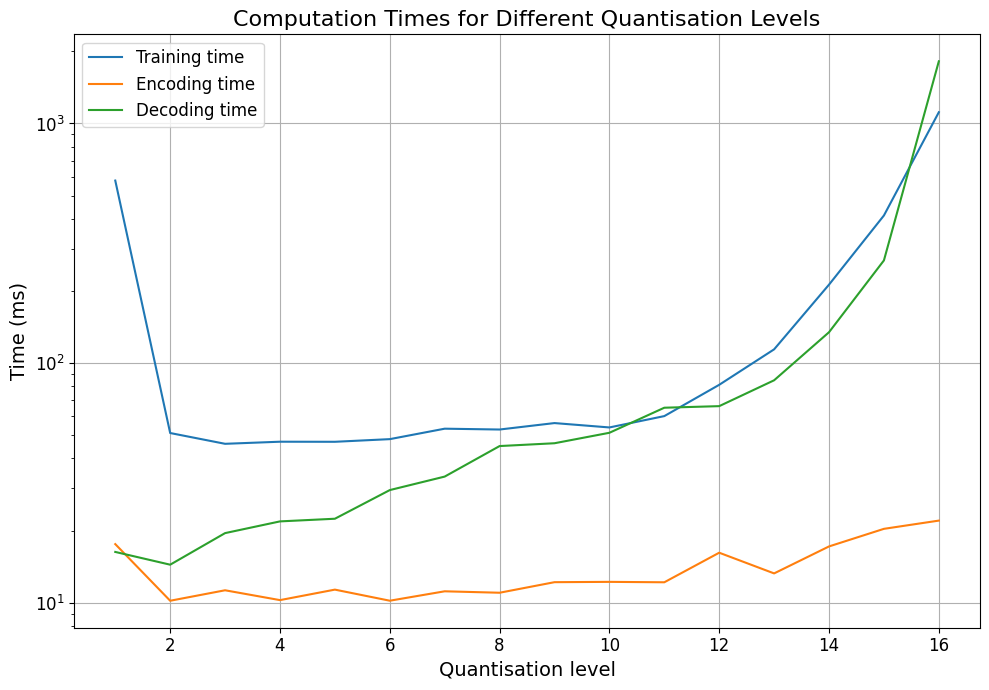

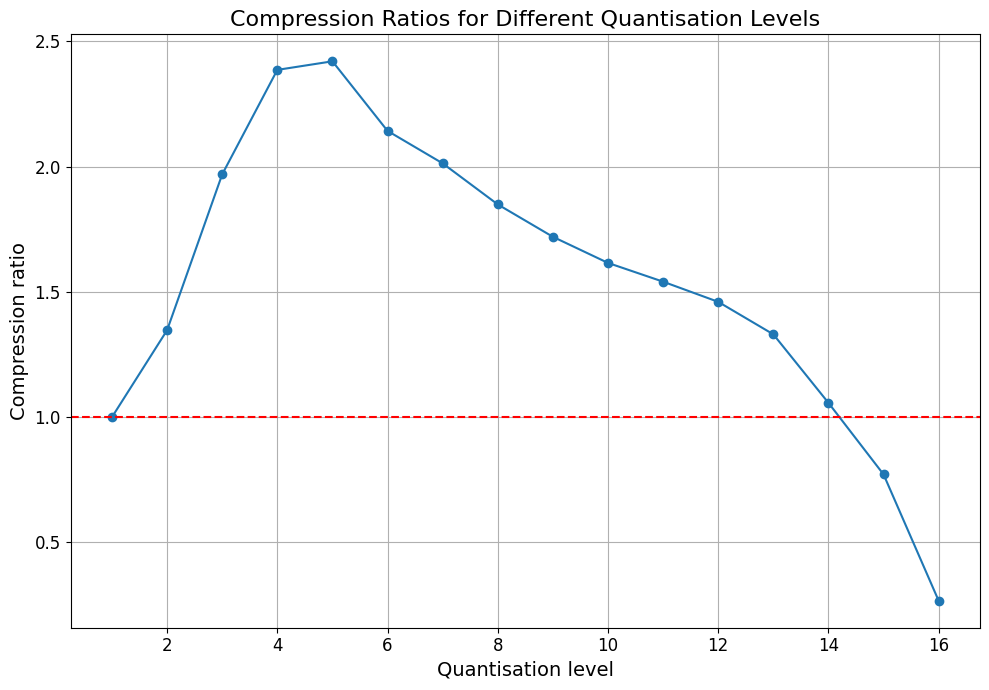

In [177]:
# Measure the computation times for different Quantisation levels
train_times = []
encode_times = []
decode_times = []
compression_ratios = []

for n in range(1, 17):
    time_start = time()
    huffman_table = init_table(train_paths)
    huffman_table, _ = create_codewords(huffman_table, do_print=False)
    train_times.append((time() - time_start)*1000)

    time_start = time()
    encoded_data = encode(test_paths[0], huffman_table)
    encode_times.append((time() - time_start)*1000)

    time_start = time()
    decoded_data = decode('encoded_data.bin', huffman_table)
    decode_times.append((time() - time_start)*1000)

    # Calculate the compression ratio
    compression_ratios.append(len(decoded_data) * n / len(encoded_data))



# Create a single plot with increased text size
plt.figure(figsize=(10, 7))
plt.plot(range(1, 17), train_times, label='Training time')
plt.plot(range(1, 17), encode_times, label='Encoding time')
plt.plot(range(1, 17), decode_times, label='Decoding time')
plt.xlabel('Quantisation level', fontsize=14)
plt.ylabel('Time (ms)', fontsize=14)
plt.yscale('log')
plt.legend(fontsize=12)
plt.grid()
plt.title('Computation Times for Different Quantisation Levels', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('time_plot.pdf', format='pdf')
plt.show()

# Plot compression ratios
plt.figure(figsize=(10, 7))
plt.plot(range(1, 17), compression_ratios, marker='o')
plt.axhline(y=1, color='r', linestyle='--', label='No compression')
plt.xlabel('Quantisation level', fontsize=14)
plt.ylabel('Compression ratio', fontsize=14)
plt.title('Compression Ratios for Different Quantisation Levels', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid()
plt.savefig('compression_plot.pdf', format='pdf')
plt.show()

In [174]:
ratios_list = []
all_paths = train_paths + test_paths 
for n in range(11,17):
    # Create Huffman tables with different amounts of training data
    huffman_tables = [init_table(all_paths[:i]) for i in range(len(all_paths)-1)]
    huffman_tables = [create_codewords(table, do_print=False)[0] for table in huffman_tables]

    # Calculate the compression ratios for the test data
    compression_ratios = []
    for i, table in enumerate(huffman_tables):
        filename = f'encoded_data_{i}.bin'
        encoded_data = encode(test_paths[-1], table, filename=filename)
        decoded_data = decode(filename, table)
        compression_ratios.append(len(decoded_data) * n / len(encoded_data))
    
    ratios_list.append(compression_ratios)



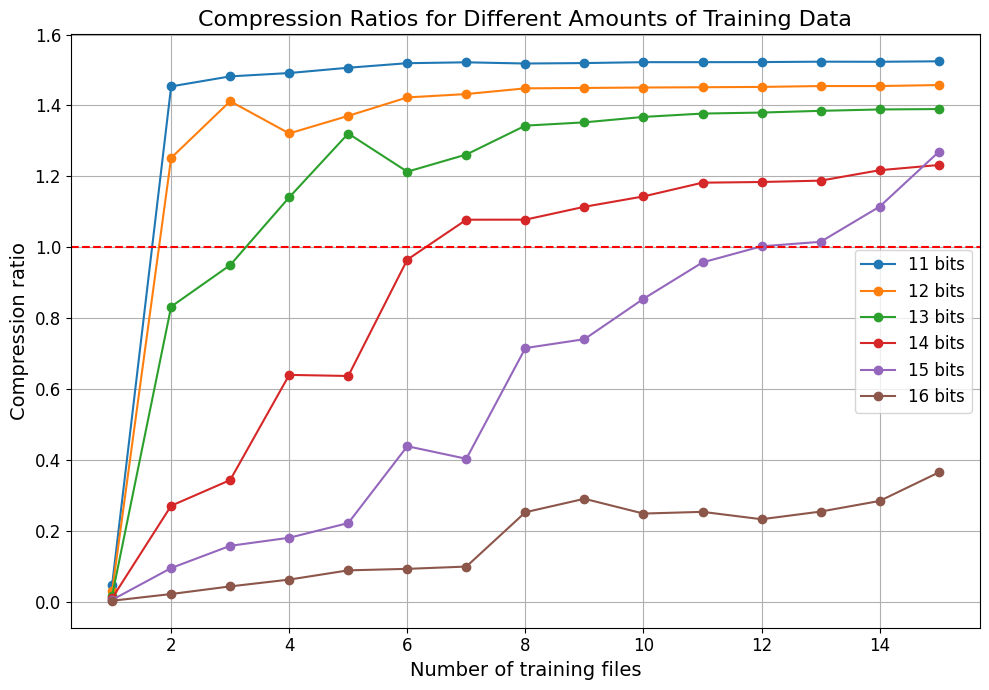

In [175]:

# Plot the compression ratios
plt.figure(figsize=(10, 7))
for i, compression_ratios in enumerate(ratios_list):
    plt.plot(range(1,len(compression_ratios)+1), compression_ratios, marker='o', label=f'{i+11} bits')

plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel('Number of training files', fontsize=14)
plt.ylabel('Compression ratio', fontsize=14)
plt.title('Compression Ratios for Different Amounts of Training Data', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid()
plt.legend(fontsize=12)
plt.savefig('compression_training_plot.pdf', format='pdf')
plt.show()



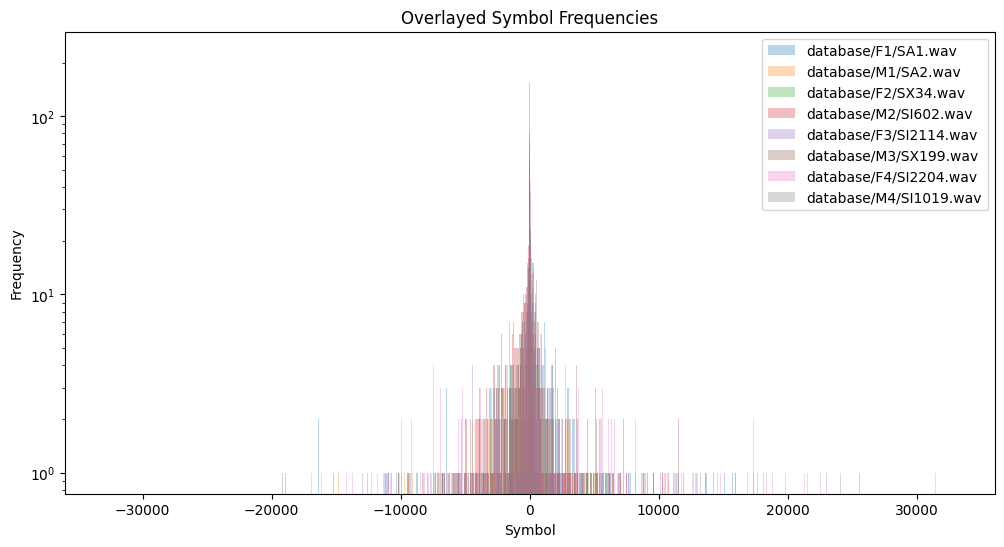

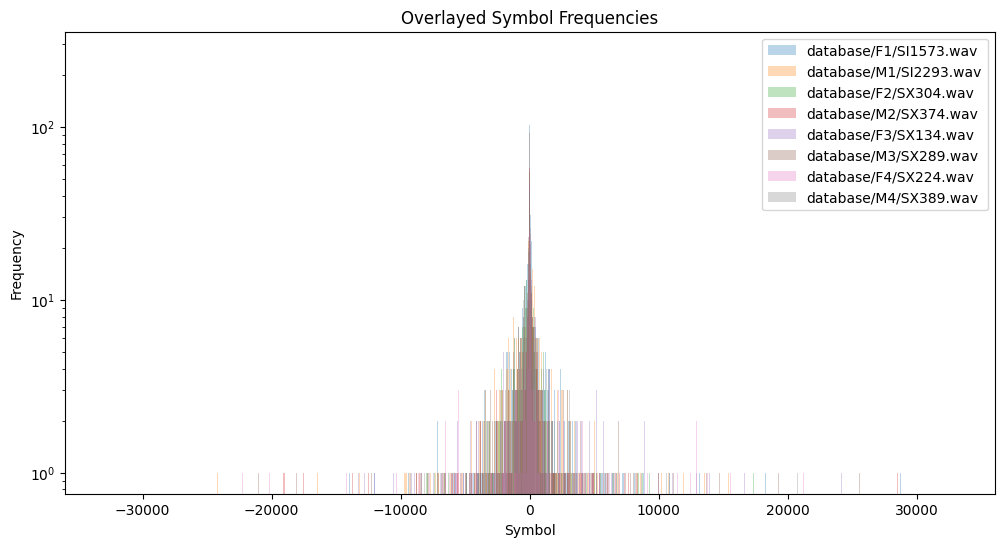

In [176]:
# Create a histogram of symbol frequencies for the training data
def plot_histogram(tables, titles):
    plt.figure(figsize=(12, 6))
    for table, title in zip(tables, titles):
        symbols = list(table.keys())
        frequencies = [data['frequency'] for data in table.values()]
        plt.hist(symbols, bins=len(symbols), weights=frequencies, alpha=0.3, label=title)
    plt.yscale('log')
    plt.title('Overlayed Symbol Frequencies')
    plt.xlabel('Symbol')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig('overlayed_histogram.pdf')
    plt.show()

huffman_tables = [init_table([path]) for path in train_paths]
plot_histogram(huffman_tables, train_paths)

huffman_tables = [init_table([path]) for path in test_paths]
plot_histogram(huffman_tables, test_paths)